In [80]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [81]:
df = pd.read_csv("../data/MLTollsStackOverflow.csv")

In [82]:
len(df)

132

In [83]:
df['month'][0]

'09-Jan'

In [84]:
df['month'].iloc[-1]

'19-Dec'

In [85]:
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


### Data Preparation

In [86]:
df['month'] = pd.to_datetime(df['month'], format="%y-%b")

In [87]:
# each column contains the number of questions for a given topic
# we are interested in the total questions asked and need to sum those columns
cols_to_sum = [col for col in df.columns if col != 'month']
df['Total_Questions'] = df[cols_to_sum].sum(axis=1).astype(int)

In [88]:
time_series_df = df.copy()
time_series_df = time_series_df[['month', 'Total_Questions']]
time_series_df

,month,Total_Questions
0,2009-01-01,832
1,2009-02-01,893
2,2009-03-01,1001
3,2009-04-01,1053
4,2009-05-01,1323
...,...,...
127,2019-08-01,45344
128,2019-09-01,43098
129,2019-10-01,52061
130,2019-11-01,51469


### Seasonal Decomposition

In [94]:
from scipy.stats import kruskal
import numpy as np
# Check if there is seasonality in our series
# check the below link for documentation of this function
# https://knk00.medium.com/how-to-determine-seasonality-without-plots-f18cee913b95
def seasonality_test(series):
        seasoanl = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal
seasonality_test(decompose_df['Total_Questions'])

True

We can reject the null hypothesis which states the series is non-seasonal.

<AxesSubplot: xlabel='month'>

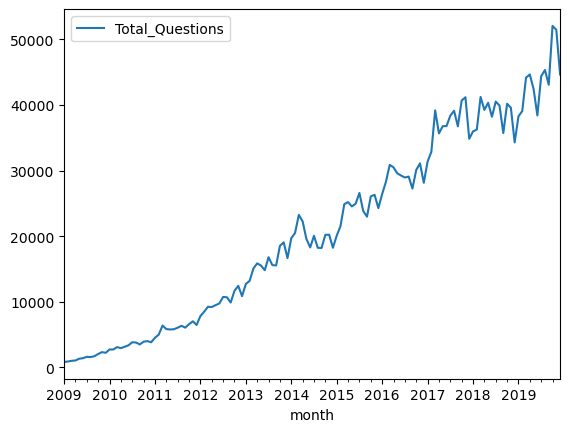

In [90]:
decompose_df = time_series_df.set_index('month')
decompose_df.plot()

The above chart shows a rather multiplicative seasonality, meaning we will need to set a specificparameter in the Facebook Prophet function. This also shows in the below chart which contains a detrended time series with increasing amplification with ongoing time.

<AxesSubplot: >

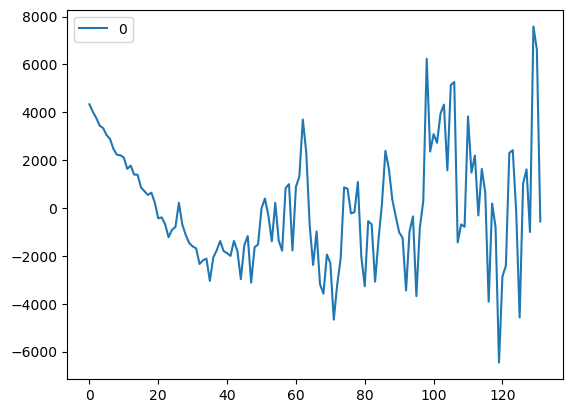

In [97]:
detrended = signal.detrend(decompose_df['Total_Questions'])
detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

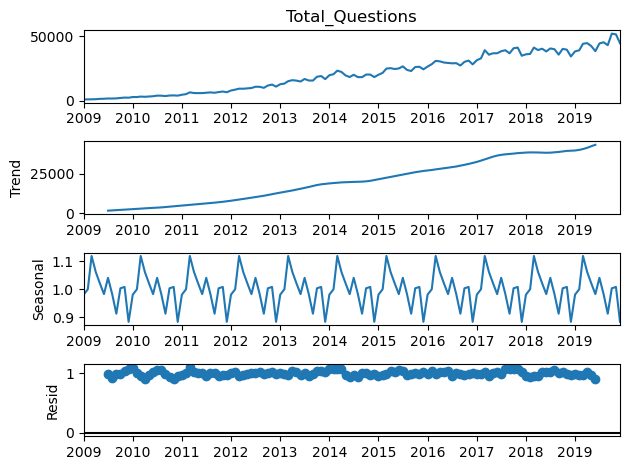

In [98]:
result = seasonal_decompose(decompose_df['Total_Questions'], model='mult')  # model='mul' also works
result.plot();

## Facebook Prophet

Prophet requires columns to be named in the below way to function

In [99]:
time_series_df.columns = ['ds','y']

19:54:57 - cmdstanpy - INFO - Chain [1] start processing
19:54:57 - cmdstanpy - INFO - Chain [1] done processing


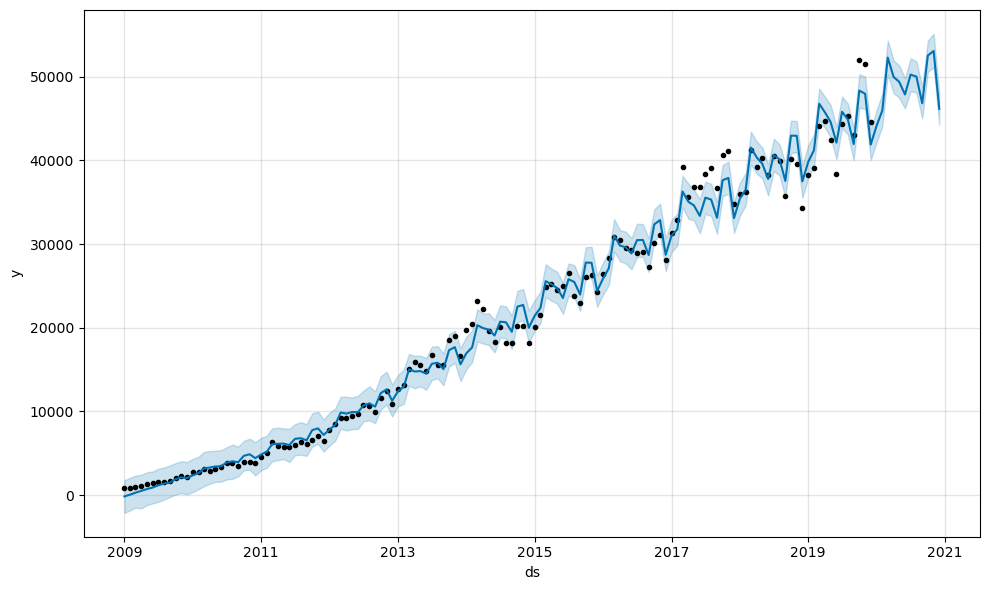

In [100]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(time_series_df)
future = m.make_future_dataframe(12, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

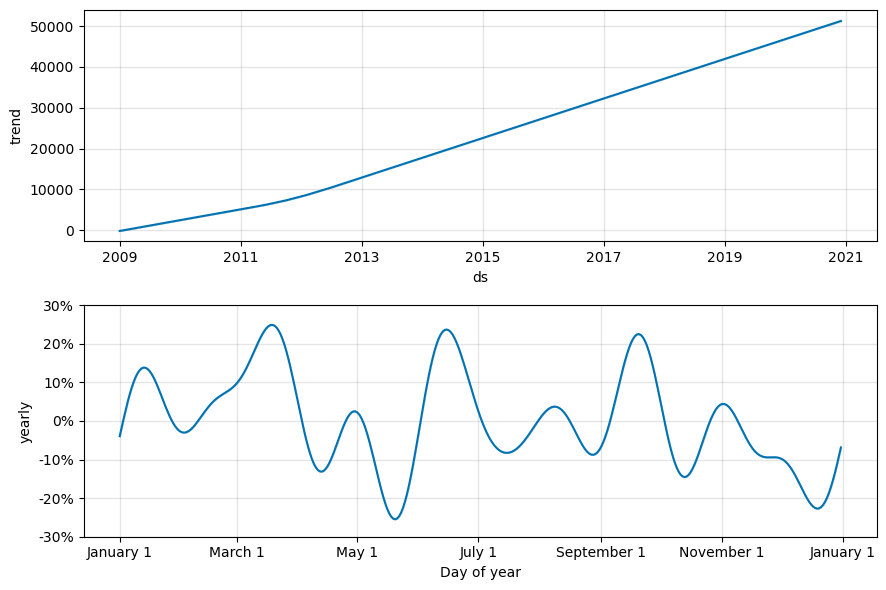

In [101]:
fig = m.plot_components(forecast)

### Interpretation and Recommendations

There are clear spikes in the above Time Series data around mid March, Mid June and Mid September, while there are expected bottoms around Christmas and an unexplained bottom towards the end of May. This bottom would be woth to investigate further.

The recommendations we can make from this depend on the business case. As an example we could recommend increased server capacity around this time.